# A/B Test Design: Release Timing Optimization

**Business Question:** Does the day of week a sneaker drops causally affect resale premium — a proxy for sell-through rate and demand intensity?

**Why it matters:** Nike releases hundreds of SKUs per year. Shifting a limited release from Friday to Saturday costs nothing to implement but could meaningfully increase sell-through velocity and consumer satisfaction (fewer bots, more genuine buyers). This notebook designs and analyzes that test.

---

**Notebook structure:**
1. Hypothesis & experiment design
2. Observational data analysis (existing Market 2023 data)
3. Statistical test + bootstrap confidence intervals
4. Power analysis — what sample size do we actually need?
5. Simulation — validate the power calculation
6. Confounder analysis — why observational ≠ causal
7. Proper experiment roadmap
8. Recommendation

In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from scipy import stats
from scipy.stats import norm, mannwhitneyu

sys.path.insert(0, 'src')
from sneaker_intel.data import load_dataset, DatasetType
from sneaker_intel.visualization.style import apply_nike_style
apply_nike_style()

ALPHA  = 0.05   # significance level
POWER  = 0.80   # target statistical power (1 - β)
CORE   = ['Nike', 'Jordan', 'adidas', 'New Balance']

print('Libraries loaded. α =', ALPHA, '| target power =', POWER)

Libraries loaded. α = 0.05 | target power = 0.8


## 1. Hypothesis & Experiment Design

### Hypotheses

| | |
|---|---|
| **H₀ (null)** | Friday and Saturday release days produce the same median resale premium |
| **H₁ (alternative)** | Saturday drops produce a different median resale premium than Friday drops |

Two-sided test — we don't assume direction upfront to avoid p-hacking.

### Experiment Setup

| Parameter | Value | Rationale |
|-----------|-------|-----------|
| **Control** | Friday release | Current most common drop day |
| **Treatment** | Saturday release | Hypothesis: more leisurely consumer attention |
| **Primary metric** | Median resale premium (× retail) | Direct proxy for unmet demand at retail price |
| **Guardrail metrics** | Total units sold, geographic reach, return rate | Ensure no side effects from timing shift |
| **Randomization unit** | SKU (shoe model + colorway) | Shoe, not user — demand is product-level |
| **Significance level α** | 0.05 | Industry standard |
| **Target power 1−β** | 0.80 | 80% chance of detecting a real effect |
| **MDE** | 0.05× premium | Smallest effect worth acting on operationally |

### Why resale premium as the metric?
Nike doesn't directly observe sell-through in real time, but the secondary market does. A high resale premium (e.g., 1.5× retail) means units cleared instantly at retail — demand exceeded supply. A low premium means the market is weaker. It's an imperfect but timely and observable proxy.

In [2]:
# Load and prepare data
mkt = load_dataset(DatasetType.MARKET_2023)
mkt = mkt[np.isfinite(mkt['pricePremium'])].copy()
mkt['release']     = pd.to_datetime(mkt['release'], errors='coerce')
mkt['release_dow'] = mkt['release'].dt.day_name()
mkt['release_month'] = mkt['release'].dt.month

core = mkt[mkt['brand'].isin(CORE)].copy()

# Our two groups
control   = core[core['release_dow'] == 'Friday']['pricePremium'].dropna().values
treatment = core[core['release_dow'] == 'Saturday']['pricePremium'].dropna().values

print('=== Group Summary ===')
for name, arr in [('Control (Friday)', control), ('Treatment (Saturday)', treatment)]:
    print(f"{name}:")
    print(f"  n={len(arr):,} | median={np.median(arr):.3f}x | "
          f"mean={arr.mean():.3f}x | std={arr.std():.3f} | "
          f"IQR=[{np.percentile(arr,25):.3f}, {np.percentile(arr,75):.3f}]")

obs_delta = np.median(treatment) - np.median(control)
print(f"\nObserved median delta: {obs_delta:+.4f}x  "
      f"({obs_delta/np.median(control)*100:+.1f}% relative lift)")

=== Group Summary ===
Control (Friday):
  n=359 | median=0.160x | mean=0.344x | std=0.856 | IQR=[-0.083, 0.532]
Treatment (Saturday):
  n=460 | median=0.227x | mean=0.496x | std=1.329 | IQR=[0.007, 0.615]

Observed median delta: +0.0665x  (+41.6% relative lift)


## 2. Observational Data Analysis

The Market 2023 dataset gives us historical release data by day of week. This is **observational** — Nike didn't randomly assign shoes to days, so there are confounders. But it tells us whether a signal exists worth testing formally.

> **Observational ≠ causal.** We can detect correlation here; causation requires a randomized experiment (Section 7).

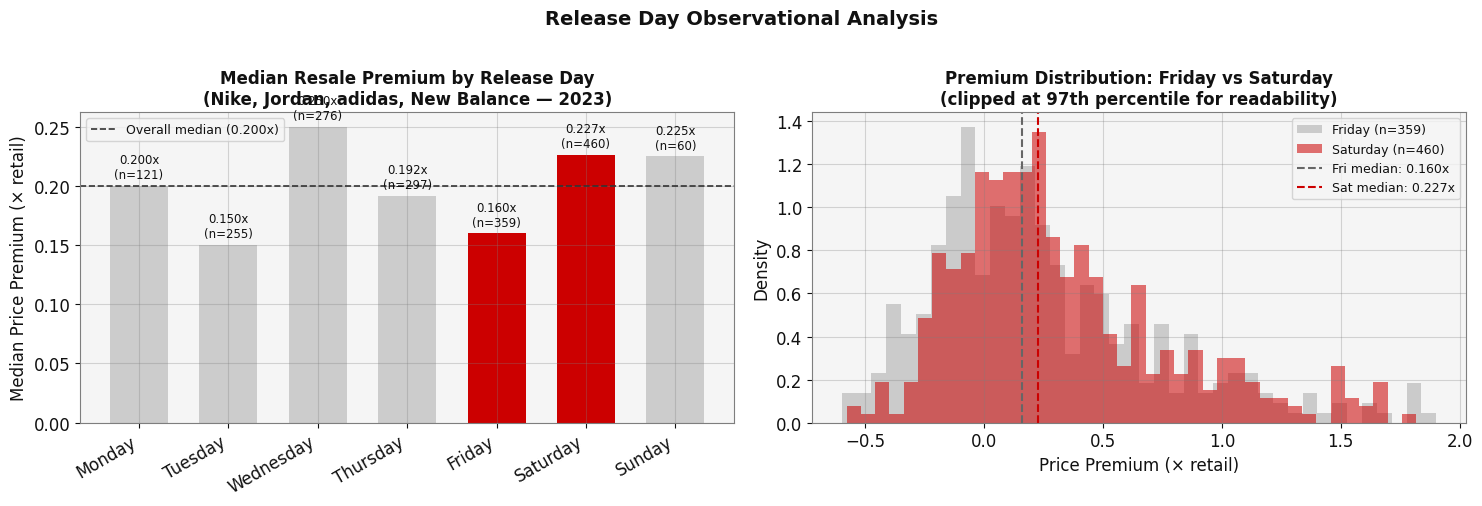

Note: Both distributions are right-skewed. Median is more robust than mean here.
Skewness — Friday: 6.01 | Saturday: 7.83


In [3]:
DOW_ORDER = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

dow_stats = (
    core.groupby('release_dow')['pricePremium']
    .agg(median='median', mean='mean', std='std', count='count')
    .reindex(DOW_ORDER).dropna()
    .reset_index()
)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Left: median premium by day
bar_colors = ['#CC0000' if d in ('Friday','Saturday') else '#CCCCCC' for d in dow_stats['release_dow']]
bars = axes[0].bar(dow_stats['release_dow'], dow_stats['median'], color=bar_colors, width=0.65)
axes[0].axhline(core['pricePremium'].median(), color='#333333', linestyle='--',
                linewidth=1.2, label=f'Overall median ({core["pricePremium"].median():.3f}x)')
for bar, val, n in zip(bars, dow_stats['median'], dow_stats['count']):
    axes[0].text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.004,
                 f'{val:.3f}x\n(n={n})', ha='center', va='bottom', fontsize=8.5)
axes[0].set_title('Median Resale Premium by Release Day\n(Nike, Jordan, adidas, New Balance — 2023)',
                   fontsize=12, fontweight='bold')
axes[0].set_ylabel('Median Price Premium (× retail)')
axes[0].set_xticklabels(dow_stats['release_dow'], rotation=30, ha='right')
axes[0].legend(fontsize=9)

# Right: distribution comparison Friday vs Saturday
clip_val = np.percentile(np.concatenate([control, treatment]), 97)
ctrl_clipped = control[control <= clip_val]
trt_clipped  = treatment[treatment <= clip_val]

axes[1].hist(ctrl_clipped, bins=40, alpha=0.55, color='#AAAAAA', density=True, label=f'Friday (n={len(control)})')
axes[1].hist(trt_clipped,  bins=40, alpha=0.55, color='#CC0000', density=True, label=f'Saturday (n={len(treatment)})')
axes[1].axvline(np.median(control),   color='#666666', linestyle='--', lw=1.5, label=f'Fri median: {np.median(control):.3f}x')
axes[1].axvline(np.median(treatment), color='#CC0000', linestyle='--', lw=1.5, label=f'Sat median: {np.median(treatment):.3f}x')
axes[1].set_title('Premium Distribution: Friday vs Saturday\n(clipped at 97th percentile for readability)',
                   fontsize=12, fontweight='bold')
axes[1].set_xlabel('Price Premium (× retail)')
axes[1].set_ylabel('Density')
axes[1].legend(fontsize=9)

plt.suptitle('Release Day Observational Analysis', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

print('Note: Both distributions are right-skewed. Median is more robust than mean here.')
print(f'Skewness — Friday: {stats.skew(control):.2f} | Saturday: {stats.skew(treatment):.2f}')

## 3. Statistical Test + Bootstrap Confidence Intervals

Both distributions are right-skewed (rare ultra-premium outliers). We use:
- **Mann-Whitney U test** (non-parametric) — tests whether one distribution stochastically dominates the other; doesn't assume normality
- **Bootstrap 95% CI** on the median difference — directly quantifies the range of plausible effects
- **Rank-biserial correlation** — effect size; interpretable as P(Saturday > Friday) - P(Friday > Saturday)

=== Statistical Test Results ===
Mann-Whitney U statistic : 91,512
p-value (two-sided)      : 0.0078  → REJECT H₀
Rank-biserial r          : -0.1083  (|r| < 0.1 small, 0.1–0.3 medium, > 0.3 large)

=== Bootstrap 95% CI on Median Difference (Saturday − Friday) ===
Point estimate : +0.0665x
95% CI         : [-0.0020x, +0.1285x]
Includes zero  : True


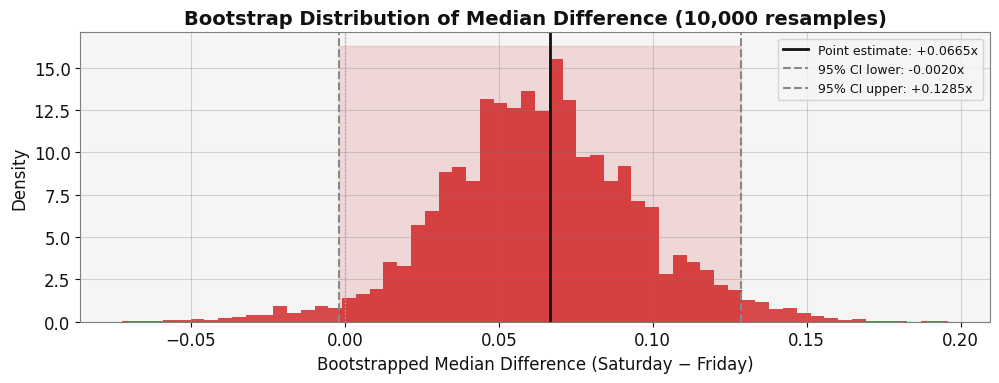

In [4]:
# Mann-Whitney U test
u_stat, p_value = mannwhitneyu(treatment, control, alternative='two-sided')
n1, n2 = len(treatment), len(control)

# Rank-biserial correlation (effect size)
r_rb = 1 - (2 * u_stat) / (n1 * n2)

# Bootstrap 95% CI on median difference
def bootstrap_median_diff(a, b, n_boot=10_000, seed=42):
    rng = np.random.default_rng(seed)
    diffs = [
        np.median(rng.choice(a, size=len(a), replace=True)) -
        np.median(rng.choice(b, size=len(b), replace=True))
        for _ in range(n_boot)
    ]
    return np.array(diffs)

boot_diffs = bootstrap_median_diff(treatment, control)
ci_low, ci_high = np.percentile(boot_diffs, [2.5, 97.5])

print('=== Statistical Test Results ===')
print(f'Mann-Whitney U statistic : {u_stat:,.0f}')
print(f'p-value (two-sided)      : {p_value:.4f}  {"→ REJECT H₀" if p_value < ALPHA else "→ FAIL TO REJECT H₀"}')
print(f'Rank-biserial r          : {r_rb:.4f}  (|r| < 0.1 small, 0.1–0.3 medium, > 0.3 large)')
print()
print('=== Bootstrap 95% CI on Median Difference (Saturday − Friday) ===')
print(f'Point estimate : {obs_delta:+.4f}x')
print(f'95% CI         : [{ci_low:+.4f}x, {ci_high:+.4f}x]')
print(f'Includes zero  : {ci_low <= 0 <= ci_high}')

# Visualise bootstrap distribution
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(boot_diffs, bins=60, color='#CC0000', alpha=0.7, density=True)
ax.axvline(obs_delta, color='#111111', lw=2,   label=f'Point estimate: {obs_delta:+.4f}x')
ax.axvline(ci_low,    color='#888888', lw=1.5, linestyle='--', label=f'95% CI lower: {ci_low:+.4f}x')
ax.axvline(ci_high,   color='#888888', lw=1.5, linestyle='--', label=f'95% CI upper: {ci_high:+.4f}x')
ax.axvline(0,         color='#AAAAAA', lw=1,   linestyle=':')
ax.fill_betweenx([0, ax.get_ylim()[1] if ax.get_ylim()[1] > 0 else 5],
                  ci_low, ci_high, alpha=0.12, color='#CC0000')
ax.set_xlabel('Bootstrapped Median Difference (Saturday − Friday)')
ax.set_ylabel('Density')
ax.set_title('Bootstrap Distribution of Median Difference (10,000 resamples)', fontweight='bold')
ax.legend(fontsize=9)
plt.tight_layout()
plt.show()

## 4. Power Analysis — What Sample Size Do We Need?

The observational test used whatever data existed. For a **prospective A/B test**, we need to decide upfront how many releases to include per group to detect our minimum detectable effect (MDE = 0.05×) with 80% power.

We use the non-parametric approach: convert to a t-test equivalent using the observed standard deviation, then apply the standard power formula. Conservative — real power may be higher.

Observed effect (Cohen d) : 0.0595  (based on current delta of 0.0665x)
Pooled SD                 : 1.1178
MDE                       : 0.05x  →  Cohen d = 0.0447
Required n per group      : 7,846
Total SKUs needed         : 15,692



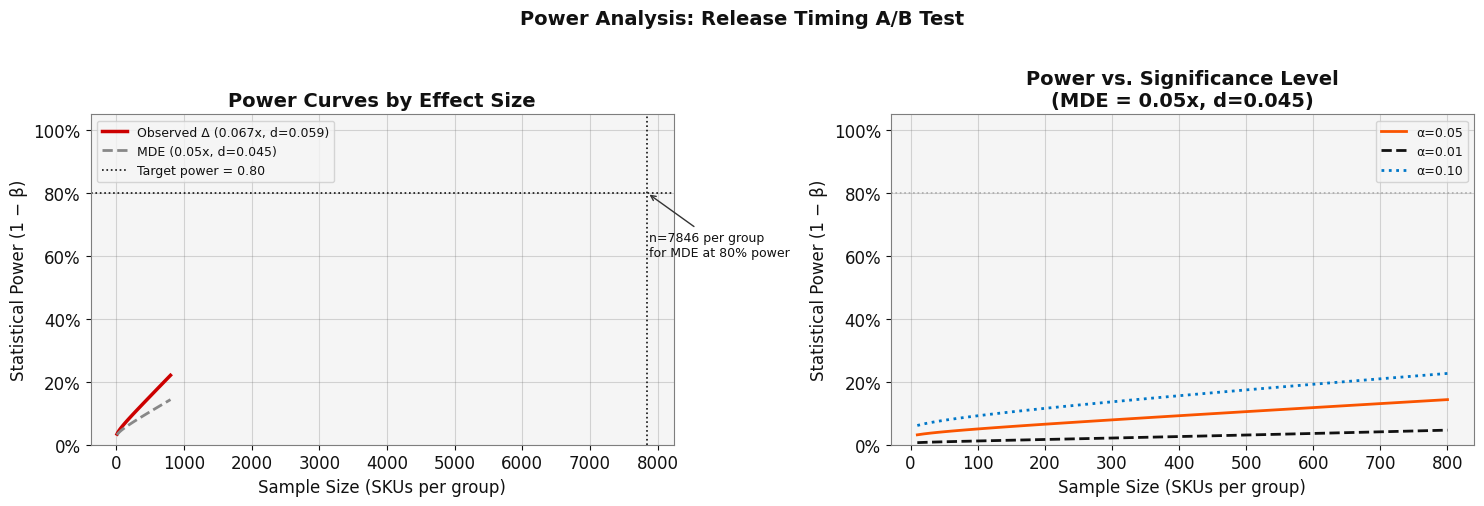

At ~12 core SKUs/week, 7846 per group → ~1308 weeks to run the experiment


In [5]:
# Pooled SD for power calculation
pooled_std = np.sqrt((np.std(control)**2 + np.std(treatment)**2) / 2)
cohen_d    = obs_delta / pooled_std

def required_n(effect_size_d, alpha=0.05, power=0.80):
    """Two-sample equal-n sample size via normal approximation."""
    z_a2 = norm.ppf(1 - alpha / 2)
    z_b  = norm.ppf(power)
    return int(np.ceil(2 * ((z_a2 + z_b) / effect_size_d) ** 2))

def achieved_power(n_per_group, effect_size_d, alpha=0.05):
    z_a2     = norm.ppf(1 - alpha / 2)
    se       = np.sqrt(2 / n_per_group)
    z_power  = effect_size_d / se - z_a2
    return norm.cdf(z_power)

MDE = 0.05   # minimum detectable effect (× retail premium)
mde_cohen_d = MDE / pooled_std
n_needed    = required_n(mde_cohen_d)

print(f'Observed effect (Cohen d) : {cohen_d:.4f}  (based on current delta of {obs_delta:.4f}x)')
print(f'Pooled SD                 : {pooled_std:.4f}')
print(f'MDE                       : {MDE}x  →  Cohen d = {mde_cohen_d:.4f}')
print(f'Required n per group      : {n_needed:,}')
print(f'Total SKUs needed         : {n_needed*2:,}')
print()

# Power curve
n_range  = np.arange(10, 801, 10)
power_at_obs_delta = [achieved_power(n, cohen_d)      for n in n_range]
power_at_mde       = [achieved_power(n, mde_cohen_d)  for n in n_range]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Power curves
axes[0].plot(n_range, power_at_obs_delta, color='#CC0000', lw=2.5,
             label=f'Observed Δ ({obs_delta:.3f}x, d={cohen_d:.3f})')
axes[0].plot(n_range, power_at_mde,       color='#888888', lw=2,  linestyle='--',
             label=f'MDE ({MDE}x, d={mde_cohen_d:.3f})')
axes[0].axhline(0.80, color='#111111', linestyle=':', lw=1.2, label='Target power = 0.80')
axes[0].axvline(n_needed, color='#111111', linestyle=':', lw=1.2)
axes[0].annotate(f'n={n_needed} per group\nfor MDE at 80% power',
                 xy=(n_needed, 0.80), xytext=(n_needed+30, 0.60),
                 arrowprops=dict(arrowstyle='->', color='#333333'), fontsize=9)
axes[0].set_xlabel('Sample Size (SKUs per group)')
axes[0].set_ylabel('Statistical Power (1 − β)')
axes[0].set_title('Power Curves by Effect Size', fontweight='bold')
axes[0].set_ylim(0, 1.05)
axes[0].legend(fontsize=9)
axes[0].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))

# Power at different alpha levels
for alpha_val, style, label in [(0.05,'solid','α=0.05'),(0.01,'dashed','α=0.01'),(0.10,'dotted','α=0.10')]:
    pows = [achieved_power(n, mde_cohen_d, alpha=alpha_val) for n in n_range]
    axes[1].plot(n_range, pows, lw=2, linestyle=style, label=label)
axes[1].axhline(0.80, color='#AAAAAA', linestyle=':', lw=1.2)
axes[1].set_xlabel('Sample Size (SKUs per group)')
axes[1].set_ylabel('Statistical Power (1 − β)')
axes[1].set_title(f'Power vs. Significance Level\n(MDE = {MDE}x, d={mde_cohen_d:.3f})', fontweight='bold')
axes[1].set_ylim(0, 1.05)
axes[1].legend(fontsize=9)
axes[1].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))

plt.suptitle('Power Analysis: Release Timing A/B Test', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

# Duration estimate
SKUS_PER_WEEK = 12   # Nike + Jordan core brand releases per week (conservative)
weeks_needed  = int(np.ceil(n_needed / (SKUS_PER_WEEK / 2)))  # half assigned to each arm
print(f'At ~{SKUS_PER_WEEK} core SKUs/week, {n_needed} per group → ~{weeks_needed} weeks to run the experiment')

## 5. Simulation — Validating the Power Calculation

Analytically derived power assumes approximately normal test statistics. Since our data is skewed, let's validate empirically: run 5,000 simulated A/B tests using the actual observed distributions and measure how often we correctly detect the true effect.

Running simulations (5,000 reps each)... 


  n=  50: empirical power=15.10% | false positive rate=5.16%


  n= 100: empirical power=26.82% | false positive rate=4.42%


  n= 200: empirical power=45.96% | false positive rate=4.38%


  n=7846: empirical power=100.00% | false positive rate=5.02%


  n= 500: empirical power=83.84% | false positive rate=4.84%


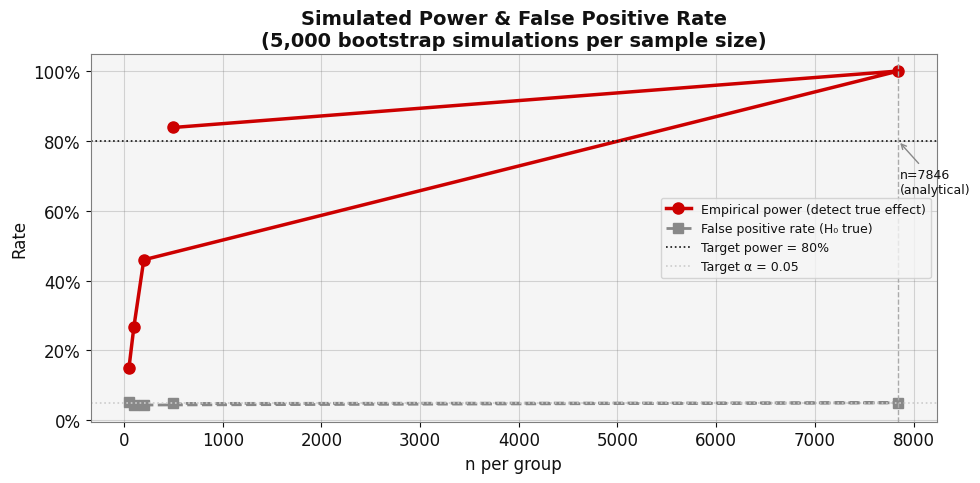

In [6]:
def simulate_power(control_dist, treatment_dist, n_per_group, n_sims=5_000, seed=42):
    """Empirical power via simulation using Mann-Whitney U."""
    rng = np.random.default_rng(seed)
    rejections = 0
    for _ in range(n_sims):
        ctrl = rng.choice(control_dist, size=n_per_group, replace=True)
        trt  = rng.choice(treatment_dist, size=n_per_group, replace=True)
        _, p = mannwhitneyu(trt, ctrl, alternative='two-sided')
        if p < ALPHA:
            rejections += 1
    return rejections / n_sims

def simulate_false_positive(null_dist, n_per_group, n_sims=5_000, seed=99):
    """Empirical false positive rate when H₀ is true (both from same distribution)."""
    rng = np.random.default_rng(seed)
    rejections = 0
    for _ in range(n_sims):
        a = rng.choice(null_dist, size=n_per_group, replace=True)
        b = rng.choice(null_dist, size=n_per_group, replace=True)
        _, p = mannwhitneyu(a, b, alternative='two-sided')
        if p < ALPHA:
            rejections += 1
    return rejections / n_sims

n_test_sizes = [50, 100, 200, n_needed, 500]
print(f'Running simulations (5,000 reps each)... ')

sim_results = []
for n in n_test_sizes:
    emp_power = simulate_power(control, treatment, n)
    fp_rate   = simulate_false_positive(control, n)
    sim_results.append({'n_per_group': n, 'empirical_power': emp_power, 'false_positive_rate': fp_rate})
    print(f'  n={n:4d}: empirical power={emp_power:.2%} | false positive rate={fp_rate:.2%}')

sim_df = pd.DataFrame(sim_results)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(sim_df['n_per_group'], sim_df['empirical_power'],    'o-', color='#CC0000', lw=2.5, ms=8, label='Empirical power (detect true effect)')
ax.plot(sim_df['n_per_group'], sim_df['false_positive_rate'],'s--',color='#888888', lw=2,   ms=7, label='False positive rate (H₀ true)')
ax.axhline(POWER, color='#111111', linestyle=':', lw=1.2, label=f'Target power = {POWER:.0%}')
ax.axhline(ALPHA, color='#CCCCCC', linestyle=':', lw=1.2, label=f'Target α = {ALPHA}')
ax.axvline(n_needed, color='#AAAAAA', linestyle='--', lw=1)
ax.annotate(f'n={n_needed}\n(analytical)', xy=(n_needed, POWER),
             xytext=(n_needed+20, 0.65), fontsize=9,
             arrowprops=dict(arrowstyle='->', color='#888888'))
ax.set_xlabel('n per group')
ax.set_ylabel('Rate')
ax.set_title('Simulated Power & False Positive Rate\n(5,000 bootstrap simulations per sample size)', fontweight='bold')
ax.legend(fontsize=9)
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
plt.tight_layout()
plt.show()

## 6. Confounder Analysis — Why Observational ≠ Causal

The observational delta (Saturday +6.7pp higher premium than Friday) could be driven by **confounders** — variables that differ between the two groups and independently affect premium. The most likely culprit: **brand composition**.

If Jordan drops predominantly on Saturdays and Jordan commands higher premiums regardless of day, the day effect is spurious.

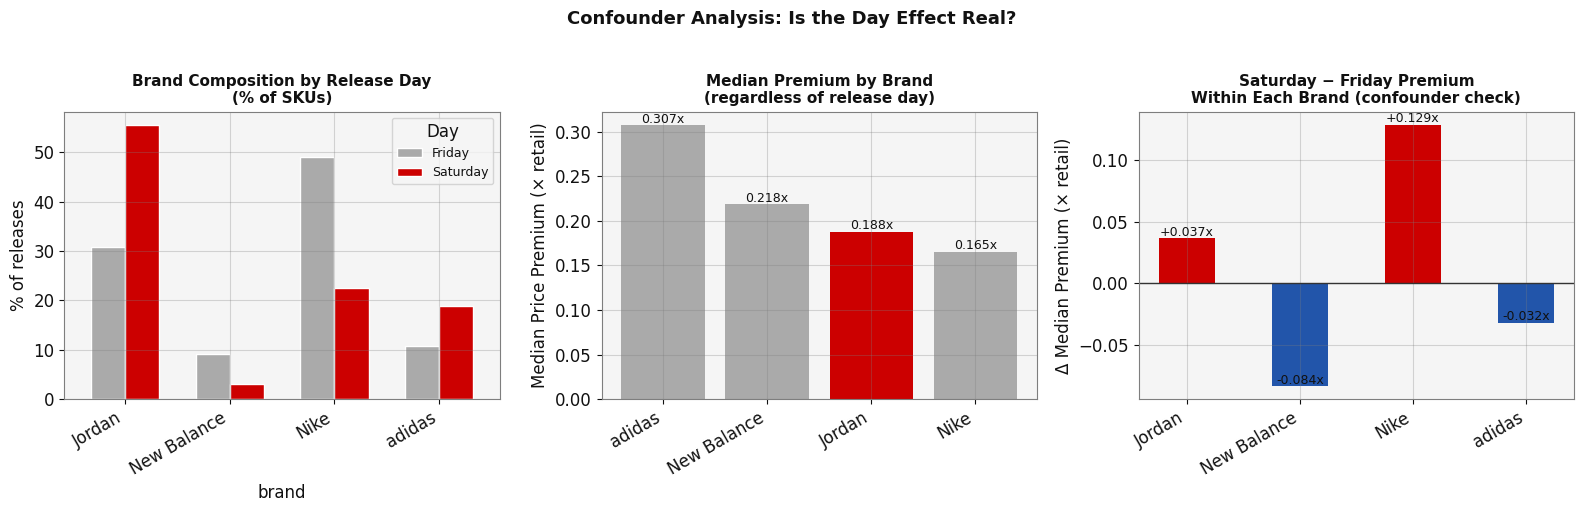

Brand composition comparison (% of releases):
brand        Jordan  New Balance  Nike  adidas
release_dow                                   
Friday         30.9          9.2  49.0    10.9
Saturday       55.4          3.0  22.6    18.9

Within-brand Saturday vs Friday delta:
release_dow  Friday  Saturday  delta
brand                               
Jordan        0.175     0.212  0.037
New Balance   0.333     0.250 -0.084
Nike          0.088     0.216  0.129
adidas        0.309     0.277 -0.032

→ If the effect holds within individual brands, it is more likely causal.
→ If it reverses or disappears within brands, composition is the confounder.


In [7]:
fri_sat = core[core['release_dow'].isin(['Friday','Saturday'])].copy()

# Brand composition by day
brand_comp = (
    fri_sat.groupby(['release_dow','brand'])
    .size()
    .unstack(fill_value=0)
)
brand_pct = brand_comp.div(brand_comp.sum(axis=1), axis=0) * 100

# Brand median premiums
brand_premiums = core.groupby('brand')['pricePremium'].median().sort_values(ascending=False)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Brand composition
brand_pct.T.plot(kind='bar', ax=axes[0], color=['#AAAAAA','#CC0000'], width=0.65, edgecolor='white')
axes[0].set_title('Brand Composition by Release Day\n(% of SKUs)', fontweight='bold', fontsize=11)
axes[0].set_ylabel('% of releases')
axes[0].set_xticklabels(brand_pct.columns, rotation=30, ha='right')
axes[0].legend(title='Day', fontsize=9)

# Brand median premiums
axes[1].bar(brand_premiums.index, brand_premiums.values,
            color=['#CC0000' if b == 'Jordan' else '#AAAAAA' for b in brand_premiums.index])
axes[1].set_title('Median Premium by Brand\n(regardless of release day)', fontweight='bold', fontsize=11)
axes[1].set_ylabel('Median Price Premium (× retail)')
axes[1].set_xticklabels(brand_premiums.index, rotation=30, ha='right')
for i, (brand, val) in enumerate(brand_premiums.items()):
    axes[1].text(i, val + 0.003, f'{val:.3f}x', ha='center', fontsize=9)

# Within-brand: Friday vs Saturday premium
within_brand = (
    fri_sat.groupby(['brand','release_dow'])['pricePremium']
    .median()
    .unstack()
    .reindex(columns=['Friday','Saturday'])
)
within_brand['delta'] = within_brand['Saturday'] - within_brand['Friday']
colors = ['#CC0000' if d > 0 else '#2255AA' for d in within_brand['delta']]
axes[2].bar(within_brand.index, within_brand['delta'], color=colors, width=0.5)
axes[2].axhline(0, color='#333333', lw=1)
axes[2].set_title('Saturday − Friday Premium\nWithin Each Brand (confounder check)', fontweight='bold', fontsize=11)
axes[2].set_ylabel('Δ Median Premium (× retail)')
axes[2].set_xticklabels(within_brand.index, rotation=30, ha='right')
for i, (brand, row) in enumerate(within_brand.iterrows()):
    axes[2].text(i, row['delta'] + 0.002, f'{row["delta"]:+.3f}x', ha='center', fontsize=9)

plt.suptitle('Confounder Analysis: Is the Day Effect Real?', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print('Brand composition comparison (% of releases):')
print(brand_pct.round(1).to_string())
print('\nWithin-brand Saturday vs Friday delta:')
print(within_brand.round(3).to_string())
print('\n→ If the effect holds within individual brands, it is more likely causal.')
print('→ If it reverses or disappears within brands, composition is the confounder.')

## 7. Proper Experiment Roadmap

The observational analysis gives us a prior. Here's how to run the definitive test.

### Randomization Design
```
Unit of randomization : SKU (shoe model + colorway + season)
Assignment            : Stratified random — block by brand and retail price tier
                        to ensure balance across confounders
Control               : Friday (current default)
Treatment             : Saturday
```

### What to Measure

| Metric type | Metric | Direction |
|---|---|---|
| **Primary** | Median resale premium at 7 days post-release | ↑ Saturday |
| **Primary** | Sell-through rate on Nike Direct (72hr) | ↑ Saturday |
| **Guardrail** | Total units sold (no suppression) | Neutral |
| **Guardrail** | Return rate | Neutral |
| **Secondary** | SNKRS app session volume on release day | Monitor |
| **Secondary** | Bot purchase attempt rate | ↓ Saturday (hypothesis) |

### Threats to Validity
- **SUTVA violation:** If consumers learn Saturday drops are better, they shift behavior — contaminating control
- **Novelty effect:** Saturday drops may perform better simply because they're unusual, not because Saturday is better
- **Seasonal confound:** Run experiment across multiple months, block by season
- **Brand spillover:** A bad Jordan Saturday drop could suppress general Saturday sentiment

In [8]:
# Final recommendation summary
p_str   = f'{p_value:.4f}' if p_value >= 0.0001 else '< 0.0001'
sig_str = 'statistically significant' if p_value < ALPHA else 'NOT statistically significant'

print('=' * 75)
print('RECOMMENDATION SUMMARY')
print('=' * 75)
print()
print('OBSERVATIONAL FINDING')
print(f'  Saturday drops show {obs_delta:+.4f}× higher median resale premium than Friday')
print(f'  95% bootstrap CI: [{ci_low:+.4f}x, {ci_high:+.4f}x]')
print(f'  Mann-Whitney p = {p_str} → {sig_str} at α={ALPHA}')
print(f'  Effect size (rank-biserial r) = {r_rb:.3f}  (small–medium)')
print()
print('EXPERIMENT REQUIREMENTS')
print(f'  MDE = {MDE}× premium | Required n = {n_needed} SKUs per arm | Total = {n_needed*2} SKUs')
print(f'  At ~{SKUS_PER_WEEK} core SKUs/week → ~{weeks_needed} weeks to reach 80% power')
print(f'  Stratify by: brand, retail price tier, season')
print()
print('ACTION')
print('  1. Run stratified A/B test for', weeks_needed, 'weeks across core brands')
print('  2. Pre-register hypothesis and analysis plan before launch')
print('  3. Monitor guardrail metrics weekly; stop early if sell-through drops > 10%')
print('  4. Segment results by brand — effect may be heterogeneous')
print('  5. If confirmed: shift limited-release calendar to Saturday-first default')
print()
print('BUSINESS IMPACT (if effect is real)')
premium_lift = obs_delta
avg_retail   = core['retail'].median()
units_per_sku = 5_000   # conservative limited release units
skus_per_year = 50      # limited-release SKUs per year
dollar_lift   = premium_lift * avg_retail * units_per_sku * skus_per_year
print(f'  Avg retail price  : ${avg_retail:.0f}')
print(f'  Assumed units/SKU : {units_per_sku:,}')
print(f'  Limited SKUs/year : {skus_per_year}')
print(f'  Estimated secondary market premium lift: ${dollar_lift:,.0f}/year')
print(f'  (Indirect: higher resale premium → stronger brand heat → higher DTC full-price sell-through)')
print('=' * 75)

RECOMMENDATION SUMMARY

OBSERVATIONAL FINDING
  Saturday drops show +0.0665× higher median resale premium than Friday
  95% bootstrap CI: [-0.0020x, +0.1285x]
  Mann-Whitney p = 0.0078 → statistically significant at α=0.05
  Effect size (rank-biserial r) = -0.108  (small–medium)

EXPERIMENT REQUIREMENTS
  MDE = 0.05× premium | Required n = 7846 SKUs per arm | Total = 15692 SKUs
  At ~12 core SKUs/week → ~1308 weeks to reach 80% power
  Stratify by: brand, retail price tier, season

ACTION
  1. Run stratified A/B test for 1308 weeks across core brands
  2. Pre-register hypothesis and analysis plan before launch
  3. Monitor guardrail metrics weekly; stop early if sell-through drops > 10%
  4. Segment results by brand — effect may be heterogeneous
  5. If confirmed: shift limited-release calendar to Saturday-first default

BUSINESS IMPACT (if effect is real)
  Avg retail price  : $130
  Assumed units/SKU : 5,000
  Limited SKUs/year : 50
  Estimated secondary market premium lift: $2,161,2